# Table of Contents
* [Summary of models](#Summary-of-models)
* [CountVectorizer with Logistic Regression](#CountVectorizer-with-Logistic-Regression)
* [Some examples of mis-classified reviews](#Some-examples-of-mis-classified-reviews)
* [Most common words in each sentiment](#Most-common-words-in-each-sentiment)
    * [1. Group by actual sentiment labels](#1.-Group-by-actual-sentiment-labels)
    * [2. Group by predicted sentiment labels](#2.-Group-by-predicted-sentiment-labels)

In [1]:
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm
#!pip install afinn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.python.keras import models, layers, optimizers
#import tensorflow
#from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
#from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
import ast
%matplotlib inline
# Training and Testing data files are available in the "../python notebook v1" directory.
# The following function finds all the .csv files in the project directory
import os
#def find_csv_filenames(path_to_dir, suffix=".csv"):
#    filenames = os.listdir(path_to_dir)
#    return [filename for filename in filenames if filename.endswith(suffix)]
#filenames = find_csv_filenames("../python notebook v1")
#for name in filenames:
#    print(name)

pd.options.display.max_colwidth = 200
import statistics
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns
import sklearn
import sqlite3
from sqlite3 import Error
import csv
#import lightgbm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Summary of models

In [2]:
result = pd.read_csv('RF_CountVectorizer_cv_rlt.csv')
best_score_CV_rf = result.best_score_.values[0]

result = pd.read_csv('NB_CountVectorizer_cv_rlt.csv')
mean_validation_score_CV_NB = result.Average_val_score[0]

result = pd.read_csv('GBM_CountVectorizer_cv_rlt.csv')
best_score_CV_LGB = result.best_score_.values[0]

result = pd.read_csv('logistic_CountVectorizer_cv_rlt.csv')
best_score_CV_Logistic = result.best_score_.values[0]

result = pd.read_csv('RF_TF_IDF_cv_rlt.csv')
best_score_TFIDF_rf = result.best_score_.values[0]

result = pd.read_csv('NB_TF_IDF_cv_rlt.csv')
mean_validation_score_TFIDF_NB = result.Average_val_score[0]

result = pd.read_csv('GBM_TF_IDF_cv_rlt.csv')
best_score_TFIDF_LGB = result.best_score_.values[0]

result = pd.read_csv('logistic_TF_IDF_cv_rlt.csv')
best_score_TFIDF_Logistic = result.best_score_.values[0]

result = pd.read_csv("NB_N_Gram_cv_rlt.csv")
mean_validation_score_NGram_NB = result.Average_val_score[0]

result = pd.read_csv('w2v_rf_cv_rlt.csv')
best_score_w2v_rf = result.best_score_.values[0]

result = pd.read_csv('w2v_GBM_cv_rlt.csv')
best_score_w2v_LGB = result.best_score_.values[0]

result = pd.read_csv('w2v_logistic_cv_rlt.csv')
best_score_w2v_Logistic = result.best_score_.values[0]

afinn_score = 0.5042096219931271

tb_score = 0.42328178694158075

In [3]:
scores = {'Accuracy Scores': ['CountVectorizer','TF-IDF','N-Gram','Word2Vec','Afinn Lexicon','TextBlob Lexicon'],
          'RandomForest': [best_score_CV_rf, best_score_TFIDF_rf, 'NA', best_score_w2v_rf, 'NA', 'NA'], 
          'Naive Bayes': [mean_validation_score_CV_NB, mean_validation_score_TFIDF_NB, 
                          mean_validation_score_NGram_NB, 'NA', 'NA', 'NA'],
          'LightGBM': [best_score_CV_LGB, best_score_TFIDF_LGB, 'NA', best_score_w2v_LGB, 'NA', 'NA'],
          'Logistic Regression': [best_score_CV_Logistic, best_score_TFIDF_Logistic, 'NA', 
                                  best_score_w2v_Logistic, 'NA', 'NA'],
          'Afinn Lexicon': ['NA', 'NA', 'NA', 'NA', afinn_score, 'NA'],
          'TextBlob Lexicon': ['NA', 'NA', 'NA', 'NA', 'NA', tb_score]         
         }
pd_score = pd.DataFrame(scores)
pd_score.set_index('Accuracy Scores')

,RandomForest,Naive Bayes,LightGBM,Logistic Regression,Afinn Lexicon,TextBlob Lexicon
Accuracy Scores,,,,,,
CountVectorizer,0.638488,0.760481,0.764433,0.787973,NA,NA
TF-IDF,0.633247,0.701804,0.760653,0.763918,NA,NA
N-Gram,NA,0.746821,NA,NA,NA,NA
Word2Vec,0.706014,NA,0.708247,0.728522,NA,NA
Afinn Lexicon,NA,NA,NA,NA,0.50421,NA
TextBlob Lexicon,NA,NA,NA,NA,NA,0.423282


## CountVectorizer with Logistic Regression

In [4]:
X_train = pd.read_csv("X_train.csv", )
y_train_0 = pd.read_csv("y_train.csv", header=None)
y_train = y_train_0[0]
X_test = pd.read_csv("X_test.csv", )
y_test_0 = pd.read_csv("y_test.csv", header=None)
y_test = y_test_0[0]

In [5]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (11640, 9)
y_train shape:  (11640,)
X_test shape:  (2911, 9)
y_test shape:  (2911,)


In [6]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Create CountVectoroizer object
vectorizer = CountVectorizer()
# Generate matrix of word vectors
X_train_matrix = vectorizer.fit_transform(X_train.text)
X_test_matrix = vectorizer.transform(X_test.text)

# Convert X_train_matrix into a DataFrame
X_train_df = pd.DataFrame(X_train_matrix.toarray())
# Map the column names to vocabulary 
X_train_df.columns = vectorizer.get_feature_names()
# keep the original ID column
X_train_df['ID'] = X_train.ID.to_list()
print(X_train_df.shape)
display(X_train_df.head())

# Convert X_test_matrix into a DataFrame
X_test_df = pd.DataFrame(X_test_matrix.toarray())
# Map the column names to vocabulary 
X_test_df.columns = vectorizer.get_feature_names()
# keep the original ID column
X_test_df['ID'] = X_test.ID.to_list()
print(X_test_df.shape)
display(X_test_df.head())

(11640, 7028)


,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,zambia,zcc,zero,zipper,zone,zoom,zuke,zurich,zz,ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7908
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,538
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4501
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13982
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6048


(2911, 7028)


,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,zambia,zcc,zero,zipper,zone,zoom,zuke,zurich,zz,ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2748
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8647
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11960
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8115
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1164


In [7]:
X_train_leftover = X_train.drop(['text'], axis=1)
# Get the full features by merging the 2 dataframes
X_train_final = pd.merge(X_train_df, X_train_leftover, how='inner', on='ID')
print(X_train_final.shape)
display(X_train_final.head())

# Drop the ID column to prepare for fitting models
X_train_no_ID = X_train_final.drop(['ID'], axis=1)
display(X_train_no_ID.head())

(11640, 7035)


,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,zurich,zz,ID,retweet_count,airline_company_American,airline_company_Delta,airline_company_Southwest,airline_company_US Airways,airline_company_United,airline_company_Virgin America
0,0,0,0,0,0,0,0,0,0,0,...,0,0,7908,0.0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,538,0.0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,4501,0.0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,13982,0.0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,6048,0.0,0,0,1,0,0,0


,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,zuke,zurich,zz,retweet_count,airline_company_American,airline_company_Delta,airline_company_Southwest,airline_company_US Airways,airline_company_United,airline_company_Virgin America
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,0,1,0,0,0


Make sure after CountVectorizer, each row still corresponds to the same observation in the original train/test dataset

In [8]:
print(X_test.text[0])
X_test_df.iloc[0,:][X_test_df.iloc[0,:] >= 1]

yes take two day get bag deliver miss full day skiing


bag           1
day           2
deliver       1
full          1
get           1
miss          1
skiing        1
take          1
two           1
yes           1
ID         2748
Name: 0, dtype: int64

In [9]:
X_test_leftover = X_test.drop(['text'], axis=1)
X_test_final = pd.merge(X_test_df, X_test_leftover, how='inner', on='ID')
print(X_test_final.shape)
display(X_test_final.head())

(2911, 7035)


,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,zurich,zz,ID,retweet_count,airline_company_American,airline_company_Delta,airline_company_Southwest,airline_company_US Airways,airline_company_United,airline_company_Virgin America
0,0,0,0,0,0,0,0,0,0,0,...,0,0,2748,1.0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,8647,0.0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,11960,0.0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,8115,0.0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1164,0.0,0,0,0,0,1,0


In [10]:
# Drop the ID column to prepare for model scoring
X_test_no_ID = X_test_final.drop(['ID'], axis=1)
display(X_test_no_ID.head())

,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,zuke,zurich,zz,retweet_count,airline_company_American,airline_company_Delta,airline_company_Southwest,airline_company_US Airways,airline_company_United,airline_company_Virgin America
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0,0,0,0,1,0


In [11]:
# Logistic regression Test performance
result = pd.read_csv('logistic_CountVectorizer_cv_rlt.csv')
best_c = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['C']
best_penalty = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['penalty']

clf = LogisticRegression(C=best_c, class_weight=None, dual=False, fit_intercept=True,
                         intercept_scaling=1, max_iter=100, solver='saga', multi_class='multinomial',
                         n_jobs=None, penalty=best_penalty, random_state=123, 
                         tol=0.0001, verbose=0, warm_start=False)

clf.fit(X_train_no_ID, y_train)

preds = clf.predict(X_test_no_ID)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, preds, labels=None, sample_weight=None)
report = classification_report(y_test, preds)
probs = clf.predict_proba(X_test_no_ID)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0] 

print("Confusion Matrix is: \n", confusion_matrix)
print("Classification Report: \n", report)
print("accuracy: %f" % (accuracy))

/Users/lisalb168/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Confusion Matrix is: 
 [[ 326   52  237]
 [  72  303  110]
 [ 155   45 1611]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.59      0.53      0.56       615
           1       0.76      0.62      0.68       485
           2       0.82      0.89      0.85      1811

   micro avg       0.77      0.77      0.77      2911
   macro avg       0.72      0.68      0.70      2911
weighted avg       0.76      0.77      0.76      2911

accuracy: 0.769495


## Some examples of mis-classified reviews

In [12]:
df_preds = pd.DataFrame(preds)
df_preds.columns = ['Prediction']
df_preds['ID'] = X_test.ID.to_list()
display(df_preds.head())
print(df_preds.shape)

,Prediction,ID
0,2,2748
1,2,8647
2,2,11960
3,1,8115
4,2,1164


(2911, 2)


In [13]:
pd.Series(preds).value_counts()

2    1958
0     553
1     400
dtype: int64

In [14]:
df_probs = pd.DataFrame(probs) 
df_probs.columns = ['Pred_Prob_0','Pred_Prob_1','Pred_Prob_2']
df_probs['ID'] = X_test.ID.to_list()
display(df_probs.head())
print(df_probs.shape)

,Pred_Prob_0,Pred_Prob_1,Pred_Prob_2,ID
0,0.004886,0.004351,0.990763,2748
1,0.009311,0.017731,0.972958,8647
2,0.082012,0.118232,0.799756,11960
3,0.262615,0.613003,0.124382,8115
4,0.028761,0.012858,0.958382,1164


(2911, 4)


In [15]:
df_y_test = pd.DataFrame(y_test) 
df_y_test.columns = ['Actual_sentiment']
df_y_test['ID'] = X_test.ID.to_list()
display(df_y_test.head())
print(df_y_test.shape)

,Actual_sentiment,ID
0,2,2748
1,2,8647
2,1,11960
3,1,8115
4,2,1164


(2911, 2)


In [16]:
d1 = pd.merge(X_test, df_y_test, how='inner', on='ID')
d2 = pd.merge(d1, df_preds, how='inner', on='ID')
d3 = pd.merge(d2, df_probs, how='inner', on='ID')
d4 = d3[['text','Actual_sentiment','Prediction']]
display(d4.head())

,text,Actual_sentiment,Prediction
0,yes take two day get bag deliver miss full day skiing,2,2
1,would fly airline actually give crap flier outside generic apology jet blue terrible,2,2
2,customer service fine,1,2
3,look forward finally take,1,1
4,b contact directly phone service laissez faire good problem cancel flightle flight,2,2


Model projected as negative, and actual is positive

In [17]:
d4.text[(d4.Actual_sentiment == 2) & (d4.Prediction == 1)]

5                                   absolutely worry never fly ever even hitch hike cross country
53                                                         call make inflight crew fact ask bring
134                      jfk nyc staff amazing jetblue send email detail disappointing experience
157                                                                                   thx respond
166                                        new like new love aa impressed subpar plane gate agent
220                                                                            response day thank
226             customer service lack owe camera also appreciate interrupt every time speak thank
238                             u want helpful save trip westchester cty jfk plus park info photo
326                                want customer frustrate thank patience jt lovely sentiment one
350                                                       comedian promise make fun stage tonight
361                 

In [18]:
# a few interesting mis-classified tweets
#free wifi make television work staticy
#thank link finally arrive brussels h schedule
#thank dishonor upgrade put seat want even notify great service
#forget reservation thank great leadership company cancel flight flight thank

Model projected as positive, and actual is negative

In [19]:
d4.text[(d4.Actual_sentiment == 1) & (d4.Prediction == 2)]

2                                                                                          customer service fine
37                                     really small thing detail make excellent experience really irritating one
57                                                                  wait hear back regard internship opportunity
95                                                                              flight time late flightly though
103                                      amazing short delay give credit literally pretty much fault miss flight
136                                                                                              good case point
139                                                        work hard make sure thing flow smoothly keep positive
145                        million miler ua fly almost every week observe gate flight crew commit good operation
151                           good thing hold flight peep late flight connect flight still make 

In [20]:
# a few interesting mis-classified tweets
#please thank mellie cae tammy baggage claim clt customer service day complaint
#touchdown jfk well pilot jetblue flight
#brian sfo customer service deserve raise give extra meal voucher good joke cheer flight delay
#2679 suck good. Based on the following context, the customer took United and says united suck, so this should be a 
#negative sentiment, rather than positive, so the original label is wrong

In [21]:
# find out the original tweet for line 2679
display(d3.ID[d3.index == 2679])
display(X_test[X_test.ID==2753])

2679    2753
Name: ID, dtype: int64

,text,retweet_count,airline_company_American,airline_company_Delta,airline_company_Southwest,airline_company_US Airways,airline_company_United,airline_company_Virgin America,ID
2679,suck good,0.0,0,0,0,0,1,0,2753


In [22]:
airline_data = pd.read_csv("../data/data_all.csv", encoding = 'utf-8')
display(airline_data[['text','retweet_count','airline']][airline_data.index==2753])

,text,retweet_count,airline
2753,@united you suck. @SouthwestAir you're the best.,0.0,United


## Most common words in each sentiment

In [23]:
# merge actual and predicted sentiments and CountVectorizer features into the same dataset
t1 = pd.merge(X_test_final, df_y_test, how='inner', on='ID')
t2 = pd.merge(t1, df_preds, how='inner', on='ID')
display(t2.head())

,aa,aaaand,aadavantage,aadv,aadvantage,aal,aas,aback,abandon,abandonment,...,ID,retweet_count,airline_company_American,airline_company_Delta,airline_company_Southwest,airline_company_US Airways,airline_company_United,airline_company_Virgin America,Actual_sentiment,Prediction
0,0,0,0,0,0,0,0,0,0,0,...,2748,1.0,0,0,0,0,1,0,2,2
1,0,0,0,0,0,0,0,0,0,0,...,8647,0.0,0,1,0,0,0,0,2,2
2,0,0,0,0,0,0,0,0,0,0,...,11960,0.0,0,0,0,1,0,0,1,2
3,0,0,0,0,0,0,0,0,0,0,...,8115,0.0,0,1,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1164,0.0,0,0,0,0,1,0,2,2


In [24]:
# columns that contains full tokenized words
t2.columns[:7027]

Index(['aa', 'aaaand', 'aadavantage', 'aadv', 'aadvantage', 'aal', 'aas',
       'aback', 'abandon', 'abandonment',
       ...
       'yyz', 'zambia', 'zcc', 'zero', 'zipper', 'zone', 'zoom', 'zuke',
       'zurich', 'zz'],
      dtype='object', length=7027)

### 1. Group by actual sentiment labels

In [25]:
group0 = t2[t2.Actual_sentiment == 0].iloc[:,:7027]
group1 = t2[t2.Actual_sentiment == 1].iloc[:,:7027]
group2 = t2[t2.Actual_sentiment == 2].iloc[:,:7027]
# sum each group
s0 = group0.sum(axis=0)
s1 = group1.sum(axis=0)
s2 = group2.sum(axis=0)
# most common k words in each sentiment category
k = 10
top_k_s0 = s0.sort_values(ascending=False)[:k]
top_k_s1 = s1.sort_values(ascending=False)[:k]
top_k_s2 = s2.sort_values(ascending=False)[:k]
display(f"Most Common {k} words in actual neutral group are: ", top_k_s0)
display(f"Most Common {k} words in actual positive group are: ", top_k_s1)
display(f"Most Common {k} words in actual negative group are: ", top_k_s2)

'Most Common 10 words in actual neutral group are: '

flight    148
get        77
thank      48
please     41
fly        35
would      34
need       33
go         31
check      28
help       26
dtype: int64

'Most Common 10 words in actual positive group are: '

thank       199
flight      103
great        53
get          47
good         45
service      34
make         33
time         29
customer     28
help         25
dtype: int64

'Most Common 10 words in actual negative group are: '

flight      641
get         295
hour        198
cancel      187
delay       169
service     166
time        146
customer    144
bag         144
wait        128
dtype: int64

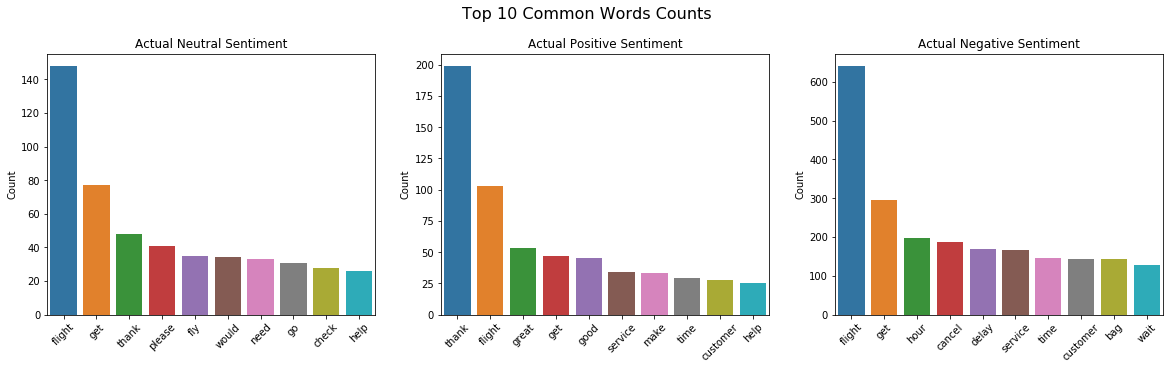

In [26]:
plt.figure(figsize=(20,5))
plt.suptitle('Top 10 Common Words Counts', fontsize=16)

plt.subplot(131)
df_top_k_s0 = pd.DataFrame(top_k_s0)
df_top_k_s0.columns = ['Count']
df_top_k_s0 = df_top_k_s0.reset_index()
g = sns.barplot(x="index", y="Count", data=df_top_k_s0)
g.set_title('Actual Neutral Sentiment', fontsize=12)
g.set_xlabel("")
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplot(132)
df_top_k_s1 = pd.DataFrame(top_k_s1)
df_top_k_s1.columns = ['Count']
df_top_k_s1 = df_top_k_s1.reset_index()
g = sns.barplot(x="index", y="Count", data=df_top_k_s1)
g.set_title('Actual Positive Sentiment', fontsize=12)
g.set_xlabel("")
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplot(133)
df_top_k_s2 = pd.DataFrame(top_k_s2)
df_top_k_s2.columns = ['Count']
df_top_k_s2 = df_top_k_s2.reset_index()
g = sns.barplot(x="index", y="Count", data=df_top_k_s2)
g.set_title('Actual Negative Sentiment', fontsize=12)
g.set_xlabel("")
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplots_adjust(hspace = 0.6, wspace = 0.2, top = 0.85)

plt.show()

### 2. Group by predicted sentiment labels

In [27]:
group0 = t2[t2.Prediction == 0].iloc[:,:7027]
group1 = t2[t2.Prediction == 1].iloc[:,:7027]
group2 = t2[t2.Prediction == 2].iloc[:,:7027]
# sum each group
s0 = group0.sum(axis=0)
s1 = group1.sum(axis=0)
s2 = group2.sum(axis=0)
# most common k words in each sentiment category
k = 10
top_k_s0 = s0.sort_values(ascending=False)[:k]
top_k_s1 = s1.sort_values(ascending=False)[:k]
top_k_s2 = s2.sort_values(ascending=False)[:k]
display(f"Most Common {k} words in predicted neutral group are: ", top_k_s0)
display(f"Most Common {k} words in predicted positive group are: ", top_k_s1)
display(f"Most Common {k} words in predicted negative group are: ", top_k_s2)

'Most Common 10 words in predicted neutral group are: '

flight    117
get        54
please     45
would      36
fly        31
fleet      30
fleek      30
go         29
ticket     28
need       26
dtype: int64

'Most Common 10 words in predicted positive group are: '

thank         234
flight         64
great          53
get            40
good           39
make           31
love           28
much           23
service        22
appreciate     22
dtype: int64

'Most Common 10 words in predicted negative group are: '

flight      711
get         325
hour        205
cancel      195
delay       189
service     189
customer    166
bag         165
time        157
wait        137
dtype: int64

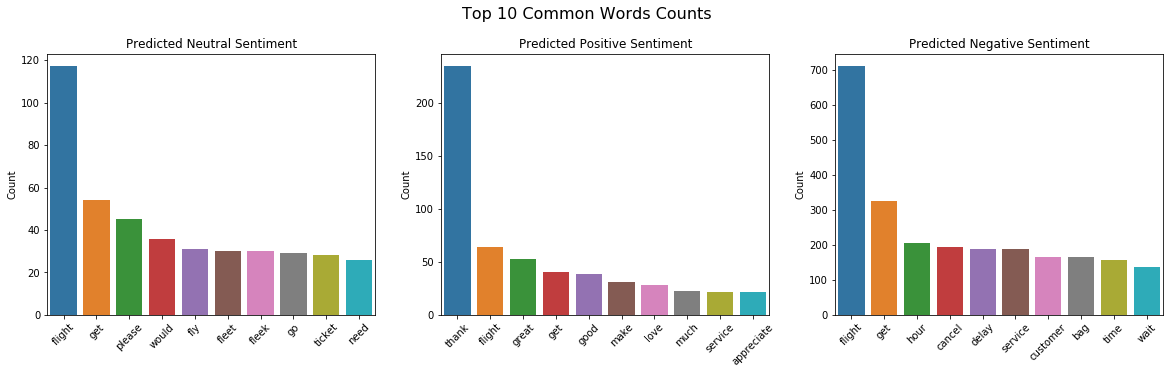

In [28]:
plt.figure(figsize=(20,5))
plt.suptitle('Top 10 Common Words Counts', fontsize=16)

plt.subplot(131)
df_top_k_s0 = pd.DataFrame(top_k_s0)
df_top_k_s0.columns = ['Count']
df_top_k_s0 = df_top_k_s0.reset_index()
g = sns.barplot(x="index", y="Count", data=df_top_k_s0)
g.set_title('Predicted Neutral Sentiment', fontsize=12)
g.set_xlabel("")
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplot(132)
df_top_k_s1 = pd.DataFrame(top_k_s1)
df_top_k_s1.columns = ['Count']
df_top_k_s1 = df_top_k_s1.reset_index()
g = sns.barplot(x="index", y="Count", data=df_top_k_s1)
g.set_title('Predicted Positive Sentiment', fontsize=12)
g.set_xlabel("")
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplot(133)
df_top_k_s2 = pd.DataFrame(top_k_s2)
df_top_k_s2.columns = ['Count']
df_top_k_s2 = df_top_k_s2.reset_index()
g = sns.barplot(x="index", y="Count", data=df_top_k_s2)
g.set_title('Predicted Negative Sentiment', fontsize=12)
g.set_xlabel("")
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplots_adjust(hspace = 0.6, wspace = 0.2, top = 0.85)

plt.show()